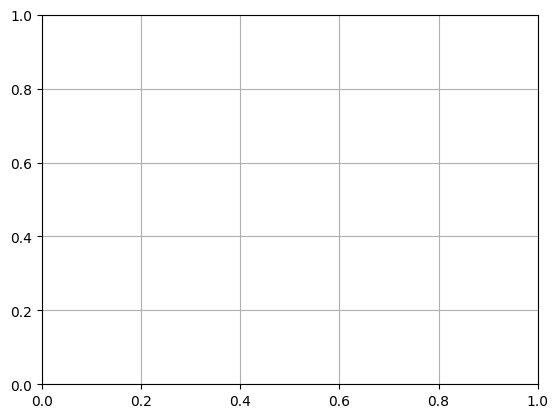

In [1]:
import matplotlib.pyplot as plt
plt.grid()

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import math

sys.path.append('..')
from mlp.parameters import parameters
from mlp.util import load_data
from mlp.model import Model

data_length = 'sim_dc_5_month'
train_data = load_data(f'train_data_{data_length}')

Test = True
if Test:
    test_file_path = r'C:\Users\e0974151\PCNN\PINN Zero\Adapt-PCNN\saves\data\test_data_sim_dc.csv'
    columns = ['SA_T', 'SA_V', 'OA_T', 'OA_H', 'ITE_P', 'RA_T']
    test_data = np.genfromtxt(test_file_path, delimiter=',', skip_header=1, usecols=range(1, len(columns)+1))
    test_data_3d_numpy = test_data[np.newaxis, :]

In [3]:
for i in range(10):
    seed = i
    interval = 1

    model_kwargs = parameters(unit='UMAR',
                                to_normalize=False,
                                name="MLP",
                                seed=seed,
                                overlapping_distance=60,
                                warm_start_length=1,
                                maximum_sequence_length=15+1,
                                minimum_sequence_length=10+1,
                                decrease_learning_rate=False,
                                learning_rate=0.005,
                                mlp_hidden_size=128,
                                mlp_num_layers=3,
                                batch_size=256,
                                division_factor=10.,
                                activation_function=1,
                                verbose=0,
                                validation_percentage=0.2)

    module = 'Adapt_PC_MLP'
    rooms = [data_length]

    # No need of info on room 274 as input
    X_columns = ['SA_T', 'SA_V', 'OA_T', 'OA_H', 'ITE_P', 'RA_T']
    Y_columns = ['RA_T']

    # Corresponding columns
    temperature_column = [-1]
    supply_T_column = [0]
    supply_m_column = [1]
    power_column = [-2]
    inputs_D = [2, 3, -1]

    topology = None 
    load = True
    load_last = False

    mlp = Model(data=train_data, interval=interval, model_kwargs=model_kwargs, inputs_D=inputs_D, 
                module=module, rooms=rooms, supply_T_column=supply_T_column, supply_m_column=supply_m_column, power_column=power_column, 
                temperature_column=temperature_column, Y_columns=Y_columns, X_columns=X_columns, topology=topology, load_last=load_last, load=load)

    train = True
    if train:
        mlp.fit(100, print_each=500)

    if Test:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        MLPmodel = mlp.model.to(device)
        MLPmodel.eval()
        
        def denormalize(value, min_val, max_val):
            return value * (max_val - min_val) + min_val
        
        def calculate_metrics(overlapping_distance, length, test_data_3d_numpy, MLPmodel, device):
            step = overlapping_distance
            NUM = math.ceil((test_data_3d_numpy.shape[1] - length) / step)

            predictions = []
            true_value = []
            min_val = 11
            max_val = 34

            for i in range(NUM):
                end_idx = min(step*i + length, test_data_3d_numpy.shape[1])
                end_idx_y = min(step*i + length + 1, test_data_3d_numpy.shape[1])

                data_input = torch.FloatTensor(test_data_3d_numpy[:, step*i:end_idx, :]).to(device)
                Y_true = torch.FloatTensor(test_data_3d_numpy[0, step*i+1:end_idx_y, -1]).to(device)

                MLPmodel.eval()
                with torch.no_grad():
                    for j in range(data_input.shape[1]):
                        pred = MLPmodel(data_input[:, j, :], warm_start=j<1)
                        true = Y_true[j]
                        predictions.append(denormalize(pred.item(), min_val, max_val))
                        true_value.append(denormalize(true.item(), min_val, max_val))

            predictions = np.array(predictions)
            true_value = np.array(true_value)

            mae = mean_absolute_error(true_value, predictions)
            mse = mean_squared_error(true_value, predictions)
            rmse = np.sqrt(mse)

            return mae, rmse
            
        # Save results to Excel
        results = []

        overlapping_distance_values = [120, 240, 360, 480, 960, 1920, 3840, 7680]
        length_values = [15, 60, 60*3, 60*6, 60*12, 60*24, 60*24*3, 60*24*7]

        for overlapping_distance, length in zip(overlapping_distance_values, length_values):
            mae, rmse = calculate_metrics(overlapping_distance, length, test_data_3d_numpy, MLPmodel, device)
            print(f'Length: {length}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
            results.append([length, mae, rmse])  # Add R² to results

        # save results
        df = pd.DataFrame(results, columns=['Length', 'MAE', 'RMSE'])
        save_path = rf'C:\Users\e0974151\PCNN\PINN Zero\Adapt-PCNN\saves\results\s_{seed}_Adapt-PC-mlp_{data_length}_softplus.xlsx'
        df.to_excel(save_path, index=False)
        print(f"Results have been saved to '{save_path}'.")

Length: 15, MAE: 0.0266, RMSE: 0.1085
Length: 60, MAE: 0.0661, RMSE: 0.1476
Length: 180, MAE: 0.1186, RMSE: 0.1724
Length: 360, MAE: 0.1592, RMSE: 0.1980
Length: 720, MAE: 0.1997, RMSE: 0.2344
Length: 1440, MAE: 0.2266, RMSE: 0.2541
Length: 4320, MAE: 0.2410, RMSE: 0.2632
Length: 10080, MAE: 0.2490, RMSE: 0.2709
Results have been saved to 'C:\Users\e0974151\PCNN\PINN Zero\Adapt-PCNN\saves\results\s_0_Adapt-PC-mlp_sim_dc_5_month_softplus.xlsx'.
Length: 15, MAE: 0.0321, RMSE: 0.1088
Length: 60, MAE: 0.0838, RMSE: 0.1524
Length: 180, MAE: 0.1580, RMSE: 0.1985
Length: 360, MAE: 0.2188, RMSE: 0.2476
Length: 720, MAE: 0.2730, RMSE: 0.2975
Length: 1440, MAE: 0.3050, RMSE: 0.3221
Length: 4320, MAE: 0.3258, RMSE: 0.3384
Length: 10080, MAE: 0.3371, RMSE: 0.3488
Results have been saved to 'C:\Users\e0974151\PCNN\PINN Zero\Adapt-PCNN\saves\results\s_1_Adapt-PC-mlp_sim_dc_5_month_softplus.xlsx'.
Length: 15, MAE: 0.0266, RMSE: 0.1058
Length: 60, MAE: 0.0627, RMSE: 0.1355
Length: 180, MAE: 0.1012, RM